# 1. Data processing and analysis 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency

In [2]:
data = pd.read_csv('sample.csv')

## 1.1. Study of the variables

### 1.1.1. ID: Loan Identifier

Studying IDs can provide a lot of information about the quality of the data set and its need for cleaning. It is necessary to study whether they are unique and whether they can contain any specific type of information.

In [3]:
unique_ids = data['ID'].is_unique
unique_ids

False

It seems that there are duplicates in the IDs, we need to study what is happening with them.

Now we proceed to study the different data prefixes. They can contain information.

In [4]:
# Extract the prefix or categorize IDs based on their initial structure
data['ID_Prefix'] = data['ID'].str.extract(r'^([A-Za-z]+)')  # Extract letters at the start
data['ID_Prefix'] = data['ID_Prefix'].fillna('Numeric')  # Label purely numeric IDs

# Group by prefix to count occurrences of each type
id_prefix_counts = data['ID_Prefix'].value_counts()

# Display the counts of each type
id_prefix_counts

RMBMUK     65035
GRNM       16876
Numeric     8110
RMBSUK      5105
LIGER       2480
HWTHN        178
KENRK        140
CMBRF        107
NWSTN         46
PRMFD         16
Name: ID_Prefix, dtype: int64

The meaning of each of the prefixes is not clear, some are more obvious like "RMBUK" or "CMBRF" but others like LIGER are not so obvious. In a study with a larger scope or more context, they can also be used to check the integrity of the data.

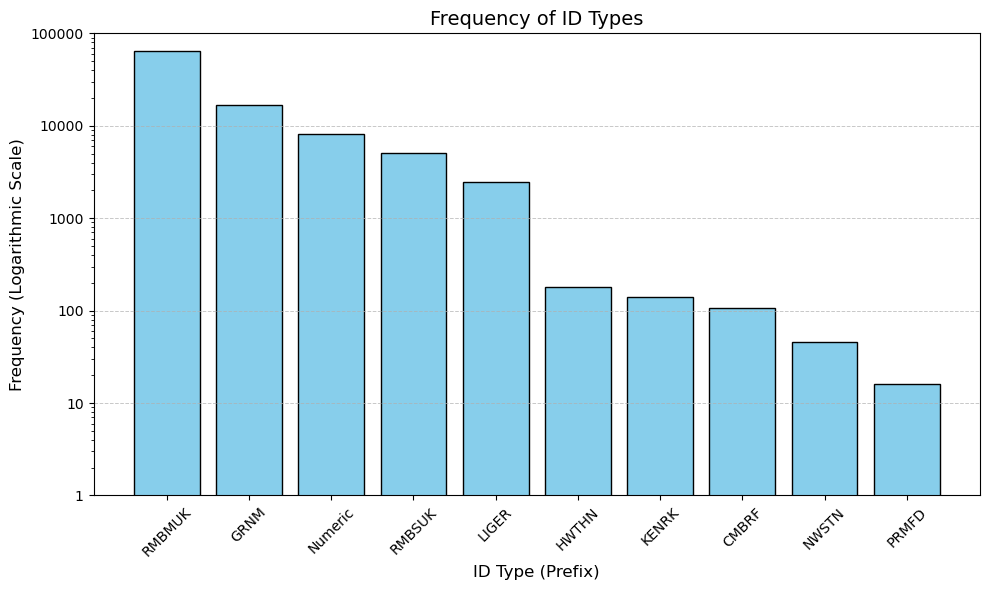

In [5]:
# Prepare data for plotting
prefixes = id_prefix_counts.index
frequencies = id_prefix_counts.values
 
# Create a logarithmic frequency plot in English
plt.figure(figsize=(10, 6))
plt.bar(prefixes, frequencies, log=True, color='skyblue', edgecolor='black')
plt.yscale('log')  # Set the y-axis to logarithmic scale
plt.ylim(1, max(frequencies)*1.1)  # Ensure all bars are fully visible

# Set real values on y-axiss
plt.yticks(
    ticks=[10**i for i in range(int(np.log10(max(frequencies))) + 2)],
    labels=[f"{int(10**i)}" for i in range(int(np.log10(max(frequencies))) + 2)]
)

# Add labels and title
plt.title("Frequency of ID Types", fontsize=14)
plt.xlabel("ID Type (Prefix)", fontsize=12)
plt.ylabel("Frequency (Logarithmic Scale)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


Compare repeated categories

In [6]:
# Contar repeticiones de IDs por categoría
id_duplicates = data.groupby('ID_Prefix')['ID'].apply(lambda x: x.duplicated().sum())

# Mostrar la cantidad de IDs repetidos por categoría
id_duplicates


ID_Prefix
CMBRF        0
GRNM       133
HWTHN        0
KENRK        1
LIGER       51
NWSTN        0
Numeric    817
PRMFD        0
RMBMUK     265
RMBSUK       7
Name: ID, dtype: int64

To not have so many different types of ID, they least frequent are group in "Other" 

In [7]:
# Identify the last 5 categories based on count and replace them with "Other"
least_common_prefixes = id_prefix_counts.nsmallest(5).index
data['ID_Prefix'] = data['ID_Prefix'].apply(lambda x: 'Other' if x in least_common_prefixes else x)

# Display the updated counts of each type
updated_id_prefix_counts = data['ID_Prefix'].value_counts()
updated_id_prefix_counts



RMBMUK     65035
GRNM       16876
Numeric     8110
RMBSUK      5105
LIGER       2480
Other        487
Name: ID_Prefix, dtype: int64

There are not many duplicate IDs and they belong to different categories, they can be deleted without facing a great loss of information. In a work with a broader scope, a case-by-case study should be carried out to try to recover some information.

ID does not containg more information.

In [8]:
data = data.drop_duplicates(subset='ID', keep=False)
data = data.drop(columns=['ID'])

### 1.1.2. Loan Origination Data, Date of Loan Maturity, Pool Cutoff Date 

1. **Loan Origination Date**: The date the mortgage is funded, marking the start of the loan and repayment schedule.

2. **Date of Loan Maturity**: The final payment date by which the loan must be fully repaid, usually defined in the mortgage agreement.

3. **Pool Cutoff Date**: The reference date for determining the composition of a pool of mortgages, often used in securitization or performance analysis.

In [9]:
# Calculate the number of missing values ​​in the three date columns
missing_dates = data[['PoolCutoffDate', 'LoanOriginationDate', 'DateOfLoanMaturity']].isna().sum()

# Show missing values ​​analysis
missing_dates


PoolCutoffDate         0
LoanOriginationDate    0
DateOfLoanMaturity     0
dtype: int64

Now clean the data to have all the dates in the same format. 

In [10]:
# Removing time from date columns (assuming columns 2, 3, and 4 are date columns with potential time values)
columns_to_clean = ["PoolCutoffDate", "LoanOriginationDate", "DateOfLoanMaturity"]


# Standardize date format to MM/DD/YYYY
for col in columns_to_clean:
    data[col] = pd.to_datetime(data[col], errors='coerce').dt.strftime('%m/%d/%Y')

# Display the cleaned data columns for verification
data[columns_to_clean].head()
data.shape[0], data.shape[1]



(96323, 25)

It is necessary to check that the data is correct and does not contain errors, we see if the origin of the debts is after they matured.


In [11]:
# Convert the relevant columns to datetime for comparison
data['PoolCutoffDate'] = pd.to_datetime(data['PoolCutoffDate'], errors='coerce')
data['LoanOriginationDate'] = pd.to_datetime(data['LoanOriginationDate'], errors='coerce')
data['DateOfLoanMaturity'] = pd.to_datetime(data['DateOfLoanMaturity'], errors='coerce')

# Identify rows where the chronological order is not respected
invalid_dates = data[
    (data['LoanOriginationDate'] >= data['PoolCutoffDate']) | 
    (data['PoolCutoffDate'] >= data['DateOfLoanMaturity'])
]

# Count and display the invalid rows
invalid_count = invalid_dates.shape[0]
invalid_count


861

In [12]:
# Remove rows where there are invalid dates based on the defined conditions
data = data[
    (data['LoanOriginationDate'] <= data['PoolCutoffDate']) & 
    (data['PoolCutoffDate'] <= data['DateOfLoanMaturity'])
]

data.shape[0], data.shape[1]


(95953, 25)

Dates are a very important metric, normally when the market falls there is a strong correlation between the different assets. To capture this temporal proximity, moving averages will be used.

Intuitively, there will be a strong autocorrelation in the series, since the economic cycle affects the number of defaults. To capture this temporal dependence, ARIMAX models (autoregressive vectors) or moving averages can be used. Due to their simplicity, moving averages will be chosen. A moving average of the target variable with a window of 3200 values ​​is added to the training dataset.

In the data that is attempted to be predicted, the value of the moving average will be assigned to the closest date.

In [13]:
# Compute 3200-point moving average based on PoolCutoffDate
data = data.sort_values(by='PoolCutoffDate').reset_index(drop=True)
data['MovingAvg3200_PoolCutoff'] = data['target'].rolling(window=3201, center=True, min_periods=1).mean()

# Compute 3200-point moving average based on LoanOriginationDate
data = data.sort_values(by='LoanOriginationDate').reset_index(drop=True)
data['MovingAvg3200_LoanOrigination'] = data['target'].rolling(window=3201, center=True, min_periods=1).mean()

# Compute 3200-point moving average based on DateOfLoanMaturity
data = data.sort_values(by='DateOfLoanMaturity').reset_index(drop=True)
data['MovingAvg3200_LoanMaturity'] = data['target'].rolling(window=3201, center=True, min_periods=1).mean()

![alt text](output.png)

There may be some kind of relationship and the original duration of the loan.

In [14]:
# Calculate the duration in months
data['DurationLoan'] = (data['DateOfLoanMaturity'].dt.year - data['LoanOriginationDate'].dt.year) * 12 + \
                       (data['DateOfLoanMaturity'].dt.month - data['LoanOriginationDate'].dt.month)

# Display the first few rows with the new column
data[['LoanOriginationDate', 'DateOfLoanMaturity', 'DurationLoan']].head()

,LoanOriginationDate,DateOfLoanMaturity,DurationLoan
0,2006-02-08,2011-02-28,60
1,2004-08-05,2011-08-31,84
2,2006-12-06,2011-12-31,60
3,2003-12-16,2011-12-31,96
4,2007-01-19,2012-01-31,60


### 1.1.3. BorrowerEmployedStatus

Intuitively important variable. With many different values. To reduce the complexity of the model to be predicted, the existing categories are reduced.

In [15]:
threshold = len(data) * 0.05

# Identify categories with less than 5% of the data
categories_to_replace = data['BorrowersEmploymentStatus'].value_counts()
categories_to_replace = categories_to_replace[categories_to_replace < threshold].index

# Replace these categories with "OTHER"
data['BorrowersEmploymentStatus'] = data['BorrowersEmploymentStatus'].replace(categories_to_replace, "OTHER")

# Verify the changes
final_data_preview = data['BorrowersEmploymentStatus'].value_counts(normalize=True) * 100
final_data_preview

EMPLOYED         63.448772
NO DATA          20.705971
SELF EMPLOYED    11.772430
OTHER             4.072827
Name: BorrowersEmploymentStatus, dtype: float64

There are different approaches to the problem of missing data. Interpolation can be attempted, but in the interest of making the model as robust as possible, the category 'NO DATA' will be retained.

In [16]:
employment_status_counts = data['BorrowersEmploymentStatus'].value_counts()
contingency_table = pd.crosstab(data['BorrowersEmploymentStatus'], data['target'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

results = {
    "Chi2 Statistic": chi2,
    "P-value": p_value,
    "Degrees of Freedom": dof,
    "Significant at 0.05": p_value < 0.05
}

results

{'Chi2 Statistic': 1660.226001498579,
 'P-value': 0.0,
 'Degrees of Freedom': 3,
 'Significant at 0.05': True}

It is statistically significant.

### 1.1.4. BorrowerType

In [17]:
# Calculate the percentage of each category in BorrowerType
borrower_type_counts = data['BorrowerType'].value_counts(normalize=True) * 100

# Convert to a DataFrame for better readability
borrower_type_percentage = borrower_type_counts.reset_index()
borrower_type_percentage.columns = ['BorrowerType', 'Percentage']

borrower_type_percentage


,BorrowerType,Percentage
0,INDIVIDUAL,71.755964
1,NO DATA,28.223193
2,COMMERCIAL,0.020844


It is possible to deduce whether the NO DATA category belongs to individuals or businesses by cross-referencing it with the BorrowerEmployedType column.

In [18]:
no_data_rows = data[data['BorrowerType'] == 'NO DATA']

# Analyze categories in BorrowersEmploymentStatus for these rows
employment_status_counts = no_data_rows['BorrowersEmploymentStatus'].value_counts()

# Display the distribution of employment status categories for rows with "NO DATA" in BorrowerType
employment_status_counts

EMPLOYED         13683
NO DATA           7391
SELF EMPLOYED     4593
OTHER             1414
Name: BorrowersEmploymentStatus, dtype: int64

Most of the categories correspond to an individual rather than a business. This column can be deleted to further simplify the model.

In [19]:
data = data.drop(columns=['BorrowerType'])

### 1.1.5. BorrowerYearOfBirth 

This column can be transformed into a very important variable: the age at which a mortgage is granted. Additionally, missing values will be flagged with a dummy variable. Interpolation will be performed once all the data has been cleaned.

C:\Users\Cash\AppData\Local\Temp\ipykernel_26536\691454951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_age_data['AgeAtLoanOrigination'] = valid_age_data['AgeAtLoanOrigination'].astype(int)
C:\Users\Cash\AppData\Local\Temp\ipykernel_26536\691454951.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_age_data['AgeAtLoanRange'] = pd.cut(valid_age_data['AgeAtLoanOrigination'], bins=age_at_loan_bins, labels=age_at_loan_labels, right=False)


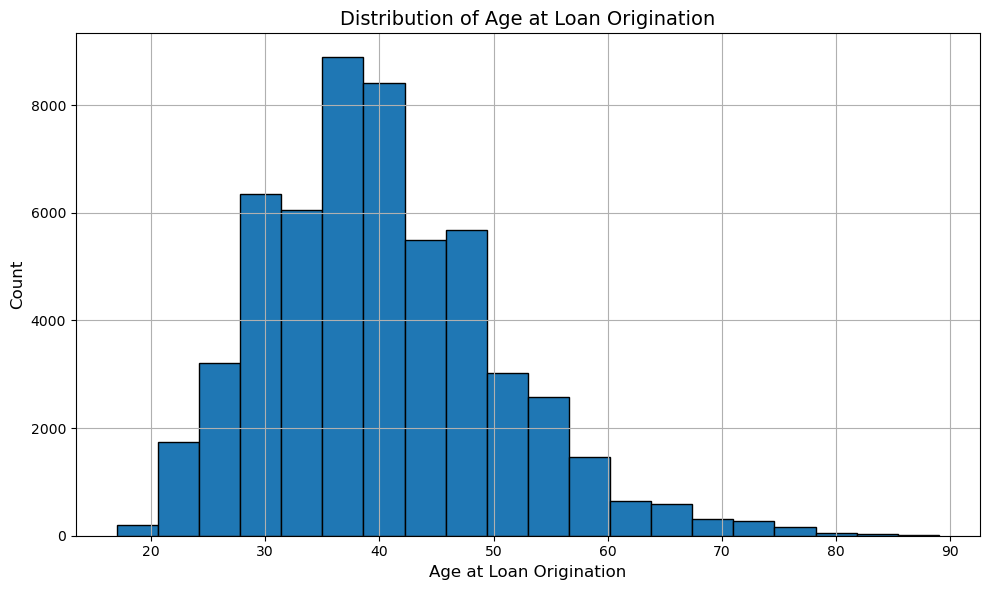

{'Min': 17,
 'Max': 89,
 'Mean': 40.06099439902844,
 'Median': 39.0,
 'Std Dev': 10.209470258104894,
 'Missing Values': 40784,
 'Unique Values': 73}

In [20]:
# Calculate age at loan origination
data['LoanOriginationDate'] = pd.to_datetime(data['LoanOriginationDate'], errors='coerce')
data['AgeAtLoanOrigination'] = data['LoanOriginationDate'].dt.year - data['BorrowerYearOfBirth']

# Filter out invalid or missing ages
valid_age_data = data.dropna(subset=['AgeAtLoanOrigination'])
valid_age_data['AgeAtLoanOrigination'] = valid_age_data['AgeAtLoanOrigination'].astype(int)

# Descriptive statistics for age at loan origination
age_at_loan_stats = {
    'Min': valid_age_data['AgeAtLoanOrigination'].min(),
    'Max': valid_age_data['AgeAtLoanOrigination'].max(),
    'Mean': valid_age_data['AgeAtLoanOrigination'].mean(),
    'Median': valid_age_data['AgeAtLoanOrigination'].median(),
    'Std Dev': valid_age_data['AgeAtLoanOrigination'].std(),
    'Missing Values': data['AgeAtLoanOrigination'].isnull().sum(),
    'Unique Values': valid_age_data['AgeAtLoanOrigination'].nunique(),
}

# Age range distribution for age at loan origination
age_at_loan_bins = [0, 25, 35, 45, 55, 65, 75, 85, 95, 105]
age_at_loan_labels = ['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85-94', '95+']
valid_age_data['AgeAtLoanRange'] = pd.cut(valid_age_data['AgeAtLoanOrigination'], bins=age_at_loan_bins, labels=age_at_loan_labels, right=False)


# Plotting the age at loan origination distribution histogram
plt.figure(figsize=(10, 6))
valid_age_data['AgeAtLoanOrigination'].hist(bins=20, edgecolor='black')
plt.title('Distribution of Age at Loan Origination', fontsize=14)
plt.xlabel('Age at Loan Origination', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()


age_at_loan_stats


The results are as expected: most loans are granted during middle age. This aligns with the other columns in the dataset, which suggest that the majority of mortgages are granted to residential clients.

In [21]:
# Drop the original 'BorrowerYearOfBirth' column
data = data.drop(columns=['BorrowerYearOfBirth'])


Dummy variables to display non-existent data.

In [22]:
# Create a new variable to mark missing values in AgeAtLoanOrigination
data['Missing_AgeAtLoanOrigination'] = data['AgeAtLoanOrigination'].isnull().astype(int)

# Verify the new variable
data[['AgeAtLoanOrigination', 'Missing_AgeAtLoanOrigination']].head()


,AgeAtLoanOrigination,Missing_AgeAtLoanOrigination
0,NaN,1
1,NaN,1
2,NaN,1
3,NaN,1
4,NaN,1


### 1.1.6. BorrowerCreditQuality & BureauScoreValue

From a business perspective, these columns are the most important. It seems obvious that perceived risk in the form of a credit score will have an obvious impact on the likelihood of default.

In [23]:
# Analyze the 'BorrowerCreditQuality' variable for unique values and missing counts
borrower_credit_quality_info = {
    "Unique Values": data['BorrowerCreditQuality'].unique(),
    "Number of Missing Values": data['BorrowerCreditQuality'].isnull().sum(),
    "Total Values": len(data['BorrowerCreditQuality']),
    "Value Counts": data['BorrowerCreditQuality'].value_counts(dropna=False).to_dict()
}

borrower_credit_quality_info


{'Unique Values': array(['No Data', 'Prime', 'PRIME', 'PASS TYPE B', 'PASS TYPE C',
        'PASS TYPE A', 'Near Prime', 'Vida 1', 'Vida 4', 'Vida 2',
        'Acquired', 'Vida 3', 'Vida 5'], dtype=object),
 'Number of Missing Values': 0,
 'Total Values': 95953,
 'Value Counts': {'No Data': 46421,
  'Prime': 33293,
  'PRIME': 6496,
  'PASS TYPE A': 3759,
  'PASS TYPE B': 3348,
  'PASS TYPE C': 2497,
  'Vida 1': 57,
  'Acquired': 48,
  'Vida 2': 13,
  'Vida 3': 8,
  'Near Prime': 7,
  'Vida 4': 5,
  'Vida 5': 1}}

The PRIME and prime categories are most likely the same, which are unified into a single category called PRIME

In [24]:
data['BorrowerCreditQuality'] = data['BorrowerCreditQuality'].replace('Prime', 'PRIME')

# Extract the BureauScoreValue column and calculate the required statistics
bureau_score_column = data['BureauScoreValue']

# Total number of rows in the dataset
total_rows = len(data)

# Non-null values in BureauScoreValue
non_null_count = bureau_score_column.notnull().sum()

# Percentage of non-null values
percentage_filled = (non_null_count / total_rows) * 100

# Basic statistics
statistics = {
    "Minimum": bureau_score_column.min(),
    "Maximum": bureau_score_column.max(),
    "Mean": bureau_score_column.mean(),
    "Standard Deviation": bureau_score_column.std(),
    "Total Values": total_rows,
    "Filled Values": non_null_count,
    "Percentage Filled": percentage_filled
}
statistics


{'Minimum': -999.0,
 'Maximum': 1440.0,
 'Mean': 940.0882671814263,
 'Standard Deviation': 237.4214628234067,
 'Total Values': 95953,
 'Filled Values': 37817,
 'Percentage Filled': 39.412003793523915}

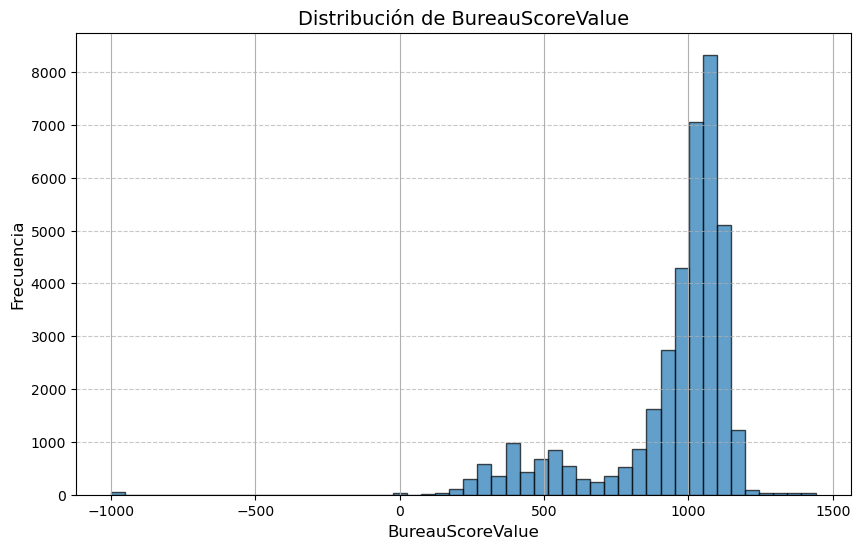

60

In [25]:
# Count of negative values in BureauScoreValue
negative_values_count = bureau_score_column[bureau_score_column < 0].count()

# Plotting the distribution
plt.figure(figsize=(10, 6))
bureau_score_column.hist(bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribución de BureauScoreValue', fontsize=14)
plt.xlabel('BureauScoreValue', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

negative_values_count


Negative values ​​are most likely an artifact and require treatment. They are assigned the average of the "BorrowerCreditQuality" category.

In [26]:
# Calculate the average of BureauScoreValue for each BorrowerCreditQuality category
category_means = data.groupby('BorrowerCreditQuality')['BureauScoreValue'].mean()

# Replace negative values in BureauScoreValue with the corresponding category mean
data.loc[data['BureauScoreValue'] < 0, 'BureauScoreValue'] = data.loc[data['BureauScoreValue'] < 0, 'BorrowerCreditQuality'].map(category_means)


In [27]:
# Add a third column for frequency, calculate BureauScoreValue mean, and sort by frequency
frequency = data['BorrowerCreditQuality'].value_counts()
relationship = data.groupby('BorrowerCreditQuality')['target'].value_counts(normalize=True).unstack()

# Format the results for better readability
relationship_percentage = relationship.fillna(0) * 100  # Convert proportions to percentages

# Add the frequency column
relationship_percentage['Frequency'] = frequency

# Calculate the mean BureauScoreValue for each BorrowerCreditQuality category
bureau_score_mean = data.groupby('BorrowerCreditQuality')['BureauScoreValue'].mean()
relationship_percentage['Mean BureauScoreValue'] = bureau_score_mean

# Sort by frequency
relationship_percentage_sorted = relationship_percentage.sort_values(by='Frequency', ascending=False)

# Display the sorted data
relationship_percentage_sorted


target,0,1,Frequency,Mean BureauScoreValue
BorrowerCreditQuality,,,,
No Data,65.136468,34.863532,46421,590.890644
PRIME,82.424791,17.575209,39789,979.498750
PASS TYPE A,69.938814,30.061186,3759,NaN
PASS TYPE B,63.231780,36.768220,3348,NaN
PASS TYPE C,52.302763,47.697237,2497,NaN
Vida 1,78.947368,21.052632,57,NaN
Acquired,54.166667,45.833333,48,NaN
Vida 2,61.538462,38.461538,13,NaN
Vida 3,75.000000,25.000000,8,NaN


This is an assumption that required a more in-depth statistical study, but due to the scope of this project, it will be taken as true. The categories with high frequency, "PRIME, PASS TYPE A, PASS TYPE B, PASS TYPE C," are high credit score categories, so the bank will focus on lending to this type of client. Only very occasionally will the bank be willing to lend to clients with a low credit score when it is certain for other reasons that the client will repay the debt. This creates a strong bias in the training data that needs to be addressed. If not addressed, the model might infer that clients with low credit scores tend to repay, even though intuitively it is known that this is not true.

In [28]:
# Recalculate frequency
frequency = data['BorrowerCreditQuality'].value_counts()

# Recalculate the relationship for target values
relationship = data.groupby('BorrowerCreditQuality')['target'].value_counts(normalize=True).unstack()
relationship_percentage = relationship.fillna(0) * 100  # Convert to percentages

# Add the frequency column
relationship_percentage['Frequency'] = frequency

# Calculate the mean BureauScoreValue
bureau_score_mean = data.groupby('BorrowerCreditQuality')['BureauScoreValue'].mean()
relationship_percentage['Mean BureauScoreValue'] = bureau_score_mean

# Calculate the mean CurrentInterestRate and CurrentInterestRateMargin
current_interest_rate_mean = data.groupby('BorrowerCreditQuality')['CurrentInterestRate'].mean()
current_interest_rate_margin_mean = data.groupby('BorrowerCreditQuality')['CurrentInterestRateMargin'].mean()
relationship_percentage['Mean CurrentInterestRate'] = current_interest_rate_mean
relationship_percentage['Mean CurrentInterestRateMargin'] = current_interest_rate_margin_mean

# Sort by frequency
relationship_percentage_sorted = relationship_percentage.sort_values(by='Frequency', ascending=False)
relationship_percentage_sorted

target,0,1,Frequency,Mean BureauScoreValue,Mean CurrentInterestRate,Mean CurrentInterestRateMargin
BorrowerCreditQuality,,,,,,
No Data,65.136468,34.863532,46421,590.890644,3.839296,2.985819
PRIME,82.424791,17.575209,39789,979.498750,2.728737,0.976739
PASS TYPE A,69.938814,30.061186,3759,NaN,3.659391,0.948529
PASS TYPE B,63.231780,36.768220,3348,NaN,3.691786,0.703187
PASS TYPE C,52.302763,47.697237,2497,NaN,3.759772,0.721538
Vida 1,78.947368,21.052632,57,NaN,3.906667,3.825088
Acquired,54.166667,45.833333,48,NaN,3.318946,2.511862
Vida 2,61.538462,38.461538,13,NaN,4.390000,4.390000
Vida 3,75.000000,25.000000,8,NaN,4.633750,4.633750


Supporting this theory, we have the interest rates. It can be observed that the averages for the categories PRIME, PASS TYPE A, PASS TYPE B, PASS TYPE C have the lowest interest rates, which gradually increase. The remaining categories have high interest rates with significant margins, which might suggest that these debts are closer to distress.

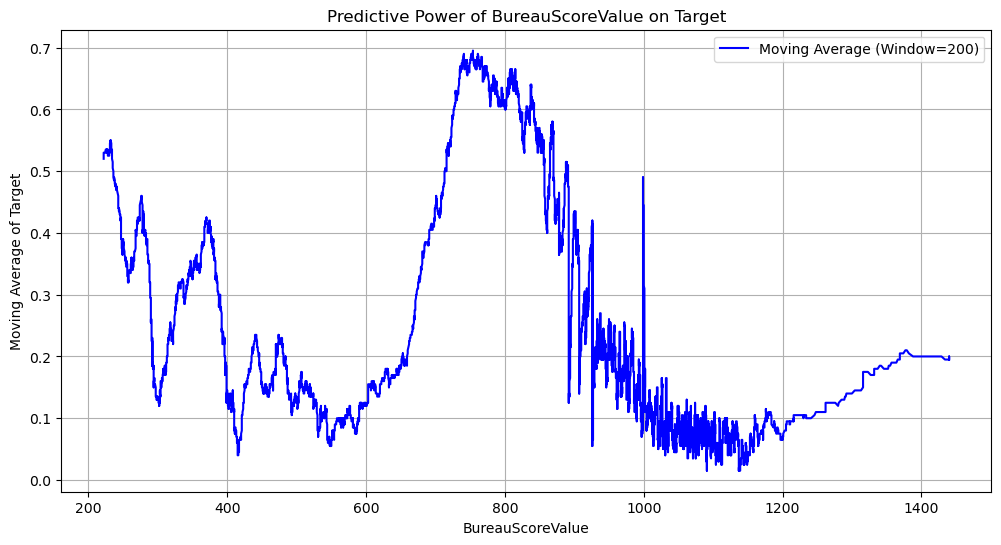

In [29]:
# Create a temporary copy of the dataset for analysis
temp_data = data.copy()

# Convert columns to numeric without modifying the original dataset
temp_data['BureauScoreValue'] = pd.to_numeric(temp_data['BureauScoreValue'], errors='coerce')
temp_data['target'] = pd.to_numeric(temp_data['target'], errors='coerce')

# Sort and filter the data
temp_data = temp_data.sort_values(by='BureauScoreValue').dropna(subset=['BureauScoreValue', 'target'])

# Calculate the rolling mean of the target variable with a window of 200
rolling_mean = temp_data['target'].rolling(window=200).mean()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(temp_data['BureauScoreValue'], rolling_mean, label='Moving Average (Window=200)', color='blue')
plt.title('Predictive Power of BureauScoreValue on Target')
plt.xlabel('BureauScoreValue')
plt.ylabel('Moving Average of Target')
plt.grid(True)
plt.legend()
plt.show()

In [30]:
general_mean = data['target'].mean()
print(f"La media general de la variable 'target' es: {general_mean}")

La media general de la variable 'target' es: 0.2790741300428335


In [31]:
# Count the number of rows with BureauScoreValue > 700 and <= 700
above_700 = data[data['BureauScoreValue'] > 700].shape[0]
below_or_equal_700 = data[data['BureauScoreValue'] <= 700].shape[0]

above_700, below_or_equal_700

(32455, 5362)

The graph clearly appears to have several phases: the first ranging from 200 to 750, from 750 to 1200, and beyond 1200.

For the second segment, from 750 to 1200, a decrease in defaults is observed as the BureauScore increases, as would be expected. This range contains the majority of the values.

In the third segment, a positive relationship is observed again, which is likely due to outliers and noise in data collection.

For the first segment [200-750], a possible interpretation is that the loans were not granted based on credit scores but rather on other variables. Individuals who received the mortgage might have had special characteristics, such as a third-party or government guarantee. This could explain why the bank decided to lend to them, why there is not much data available, and why there is significant volatility.

### 1.1.7. ConstructionYear

In [32]:
# Count the number of missing values in the ConstructionYear column
missing_construction_year_count = data['ConstructionYear'].isna().sum()

missing_construction_year_count


76968

The ConstructionYear category is almost empty.

In [33]:
buildings_after_loan_origination = data[data['ConstructionYear'] > data['LoanOriginationDate'].dt.year].shape[0]
buildings_after_loan_origination 

4

In [34]:
# Calculate the year difference for buildings constructed after their loan origination date
year_differences = data[data['ConstructionYear'] > data['LoanOriginationDate'].dt.year]
year_differences['YearDifference'] = year_differences['ConstructionYear'] - year_differences['LoanOriginationDate'].dt.year

# Get the unique differences or summary statistics
year_difference_summary = year_differences['YearDifference'].describe()

year_difference_summary

C:\Users\Cash\AppData\Local\Temp\ipykernel_26536\2479981196.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_differences['YearDifference'] = year_differences['ConstructionYear'] - year_differences['LoanOriginationDate'].dt.year


count    4.0
mean     2.0
std      2.0
min      1.0
25%      1.0
50%      1.0
75%      2.0
max      5.0
Name: YearDifference, dtype: float64

No information is provided about potential errors in the dates. Additionally, the age of the buildings is already partially reflected in the start dates of the mortgages. Therefore, this column can be removed.

In [35]:
data.drop(columns=['ConstructionYear'], inplace=True)

### 1.1.8. CurrentInterestRate & CurrentInterestRateMargin

These variables have already been used to observe some correlation and explainability regarding credit scores. This section focuses solely on their integrity and the absence of artifacts. 

From a business perspective, these columns are the most important. A higher interest rate implies a higher risk of default in several ways. First, it is more difficult for the creditor to pay. Second, knowing that there is a higher risk, the bank takes it into account by charging higher interest.

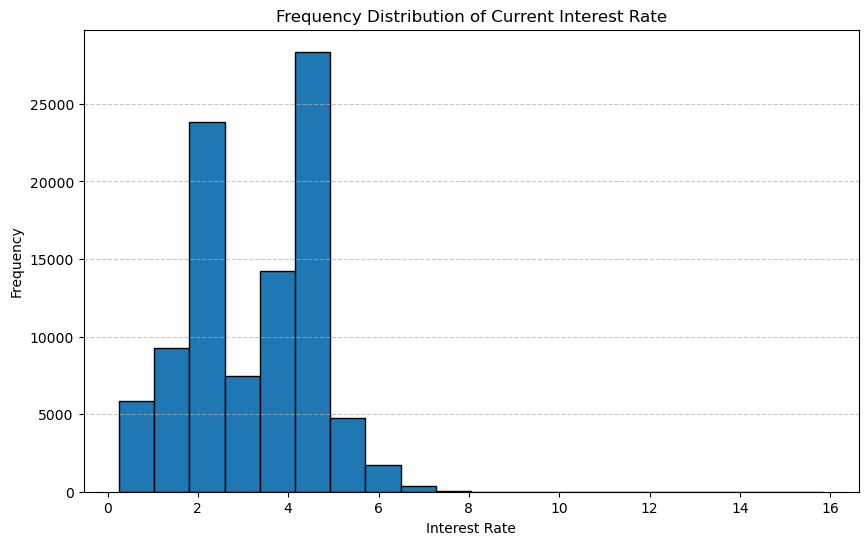

count    95953.000000
mean         3.364833
std          1.396217
min          0.250000
25%          2.500000
50%          3.590000
75%          4.740000
max         15.850000
Name: CurrentInterestRate, dtype: float64

In [36]:
# Analyze the CurrentInterestRate column
current_interest_rate = data['CurrentInterestRate']

# Basic statistics for CurrentInterestRate
current_interest_stats = current_interest_rate.describe()

# Frequency distribution for CurrentInterestRate
frequency_distribution = current_interest_rate.value_counts(bins=10).reset_index()
frequency_distribution.columns = ['Interest Rate Range', 'Frequency']

# Plot the frequency distribution
plt.figure(figsize=(10, 6))
plt.hist(current_interest_rate, bins=20, edgecolor='black')
plt.title('Frequency Distribution of Current Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


current_interest_stats 

In [37]:
# Count the number of missing values in CurrentInterestRate
missing_values_count = current_interest_rate.isnull().sum()
missing_values_count


0

No values are missing, all data is positive, and there are no clear outliers.

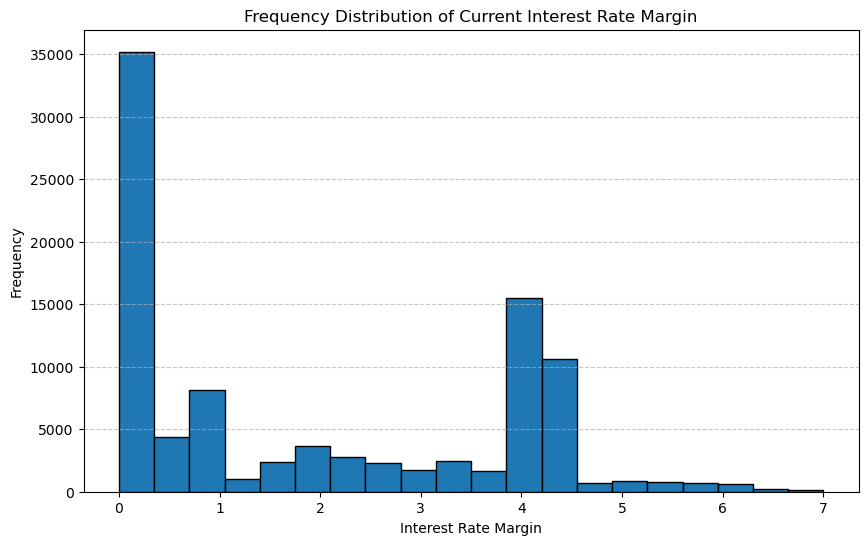

count    95953.000000
mean         1.935246
std          1.899542
min          0.000000
25%          0.000000
50%          1.190000
75%          4.090000
max          7.000000
Name: CurrentInterestRateMargin, dtype: float64

In [38]:
# Analyze the CurrentInterestRateMargin column
current_interest_rate_margin = data['CurrentInterestRateMargin']

# Basic statistics for CurrentInterestRateMargin
current_interest_margin_stats = current_interest_rate_margin.describe()

# Frequency distribution for CurrentInterestRateMargin
frequency_distribution_margin = current_interest_rate_margin.value_counts(bins=10).reset_index()
frequency_distribution_margin.columns = ['Interest Rate Margin Range', 'Frequency']

# Plot the frequency distribution
plt.figure(figsize=(10, 6))
plt.hist(current_interest_rate_margin, bins=20, edgecolor='black')
plt.title('Frequency Distribution of Current Interest Rate Margin')
plt.xlabel('Interest Rate Margin')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

current_interest_margin_stats


In [39]:
# Count the number of missing values in CurrentInterestRateMargin
missing_values_count_margin = current_interest_rate_margin.isnull().sum()
missing_values_count_margin


0

No values are missing, all data is positive, and there are no clear outliers.

### 1.1.9. FinalMargin

The FinalMargin is understood by the author of this project as the difference between the MMR (likely LIBOR, as it originates from the UK) and a spread added by the bank. This FinalMargin will be charged during the last 12 months of the loan.

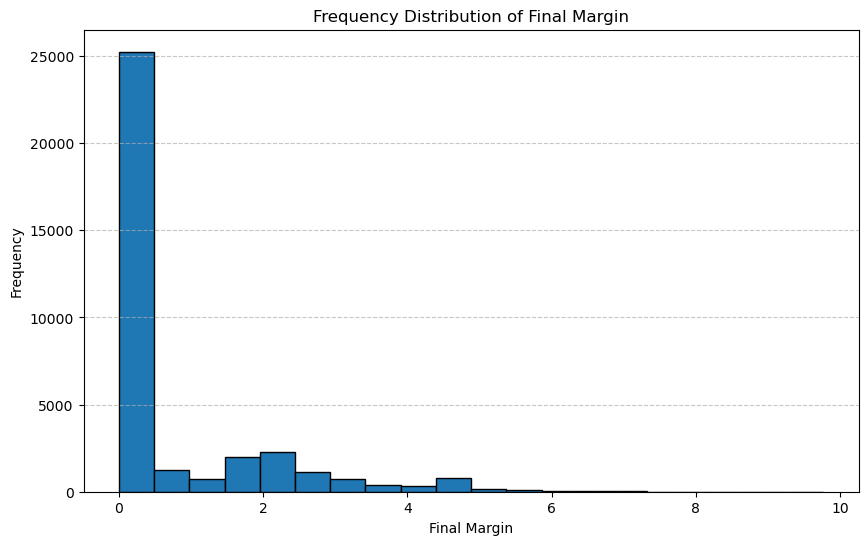

count    35199.000000
mean         0.670531
std          1.250082
min          0.000000
25%          0.000000
50%          0.000000
75%          0.950000
max          9.770000
Name: FinalMargin, dtype: float64

In [40]:
# Analyze the FinalMargin column
final_margin = data['FinalMargin']

# Basic statistics for FinalMargin
final_margin_stats = final_margin.describe()

# Frequency distribution for FinalMargin
frequency_distribution_margin = final_margin.value_counts(bins=10).reset_index()
frequency_distribution_margin.columns = ['Final Margin Range', 'Frequency']

# Plot the frequency distribution
plt.figure(figsize=(10, 6))
plt.hist(final_margin.dropna(), bins=20, edgecolor='black')
plt.title('Frequency Distribution of Final Margin')
plt.xlabel('Final Margin')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

final_margin_stats


In [41]:
# Calculate the count and percentage of null values in FinalMargin
final_margin_null_count = final_margin.isna().sum()
final_margin_null_percentage = (final_margin_null_count / len(data)) * 100

final_margin_null_count, final_margin_null_percentage

(60754, 63.316415328337825)

It is possible to try interpolating the variable or creating dummy variables to indicate when a value is present or not. However, given the scope of this project and the aim to keep the model as simple as possible to ensure greater robustness, this variable will be discarded. A possible business-driven explanation for this decision is that information about the expected interest rate is already captured, to some extent, in CurrentInterestRate and CurrentInterestRate Margin. Additionally, it is not common for mortgage defaults to occur in the last 12 months of the loan.

In [42]:
data = data.drop(columns = ['FinalMargin'])

### 1.1.10. CurrentValuationAmount

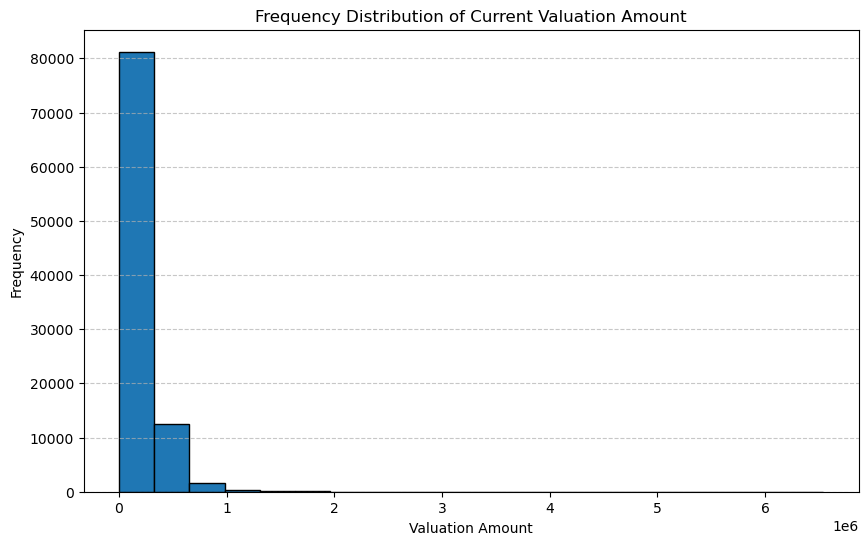

count    9.591900e+04
mean     2.165381e+05
std      1.732427e+05
min      1.070000e+00
25%      1.162263e+05
50%      1.700868e+05
75%      2.600602e+05
max      6.542383e+06
Name: CurrentValuationAmount, dtype: float64

In [43]:
# Analyze the CurrentValuationAmount column
current_valuation_amount = data['CurrentValuationAmount']

# Basic statistics for CurrentValuationAmount
current_valuation_stats = current_valuation_amount.describe()

# Frequency distribution for CurrentValuationAmount
frequency_distribution_valuation = current_valuation_amount.value_counts(bins=10).reset_index()
frequency_distribution_valuation.columns = ['Valuation Amount Range', 'Frequency']

# Plot the frequency distribution
plt.figure(figsize=(10, 6))
plt.hist(current_valuation_amount.dropna(), bins=20, edgecolor='black')
plt.title('Frequency Distribution of Current Valuation Amount')
plt.xlabel('Valuation Amount')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Count the number of missing values in CurrentValuationAmount
missing_values_count_valuation = current_valuation_amount.isnull().sum()
current_valuation_stats

In [44]:
missing_values_count_valuation

34

The values make sense; there are no negatives. There are small values (6053), but this could correspond to inexpensive houses. The large values are around 6.5 million, which is within the expected range. There are 26 missing values, which will be interpolated to recover them.

### 1.1.11. FirstTimeBuyer

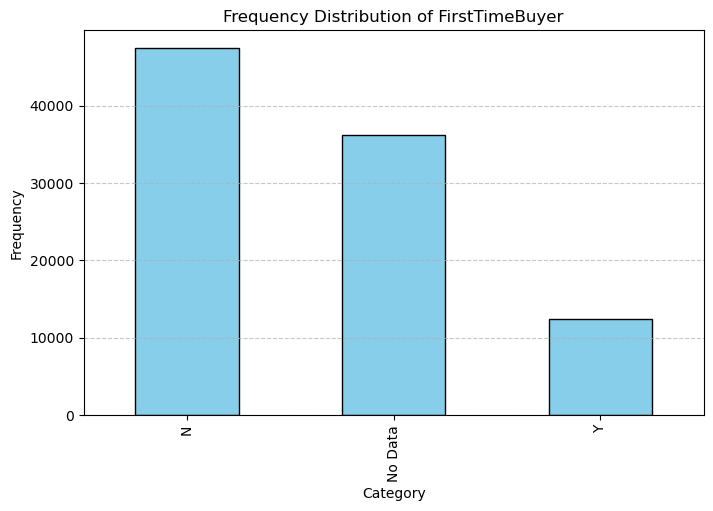

In [45]:
# Analyze the FirstTimeBuyer column
first_time_buyer = data['FirstTimeBuyer']

# Basic statistics and frequency distribution for FirstTimeBuyer
first_time_buyer_stats = first_time_buyer.value_counts()
missing_percentage_first_time_buyer = first_time_buyer.isnull().mean() * 100

# Combine basic summary into a DataFrame
first_time_buyer_summary = pd.DataFrame({
    'Total Observations': [len(first_time_buyer)],
    'Non-Missing Observations': [first_time_buyer.notnull().sum()],
    'Missing Percentage (%)': [missing_percentage_first_time_buyer],
    'Unique Categories': [first_time_buyer.nunique()],
    'Most Frequent Category': [first_time_buyer.value_counts().idxmax()],
    'Frequency of Most Frequent': [first_time_buyer.value_counts().max()],
})

# Frequency distribution
frequency_distribution_first_time_buyer = first_time_buyer.value_counts().reset_index()
frequency_distribution_first_time_buyer.columns = ['Category', 'Frequency']

# Plot the frequency distribution
plt.figure(figsize=(8, 5))
first_time_buyer.value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frequency Distribution of FirstTimeBuyer')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [46]:
summary = data.groupby('FirstTimeBuyer')['target'].agg(['mean', 'count']).reset_index()
summary.rename(columns={'mean': 'Target_Mean', 'count': 'Count'}, inplace=True)
summary

,FirstTimeBuyer,Target_Mean,Count
0,N,0.240621,47394
1,No Data,0.330885,36209
2,Y,0.274737,12350


In [47]:
# Prepare a contingency table for the statistical test
contingency_table = pd.crosstab(data['FirstTimeBuyer'], data['target'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Result interpretation
result = {
    "Chi2 Statistic": chi2,
    "P-Value": p,
    "Degrees of Freedom": dof,
    "Is Significant": p < 0.05  # Assuming a significance level of 0.05
}

result


{'Chi2 Statistic': 832.574712373054,
 'P-Value': 1.61695644636864e-181,
 'Degrees of Freedom': 2,
 'Is Significant': True}

There are two categories and missing data. After the Chi test, it is shown that there is a difference; however, there is significant uncertainty since most defaults come from the missing data. This uncertainty can potentially be reduced by using the created variable *AgeAtLoanOrigination*, as it can be assumed that individuals under 35 years old are likely taking out their first mortgage.

### 1.1.12. FlexibleLoanAmount

FlexibleLoanAmount refers to the current amount a borrower can access (or "withdraw") from a flexible loan, allowing for scheduled or early repayments while also permitting the re-use of part of the repaid amount if the contract allows. It represents the remaining credit available under a flexible financing product, unlike a traditional loan. Key features include:

Early repayments: The borrower can repay principal early, reducing the outstanding balance.
Additional withdrawals: Depending on the agreement, the borrower can re-access repaid funds up to the approved limit.

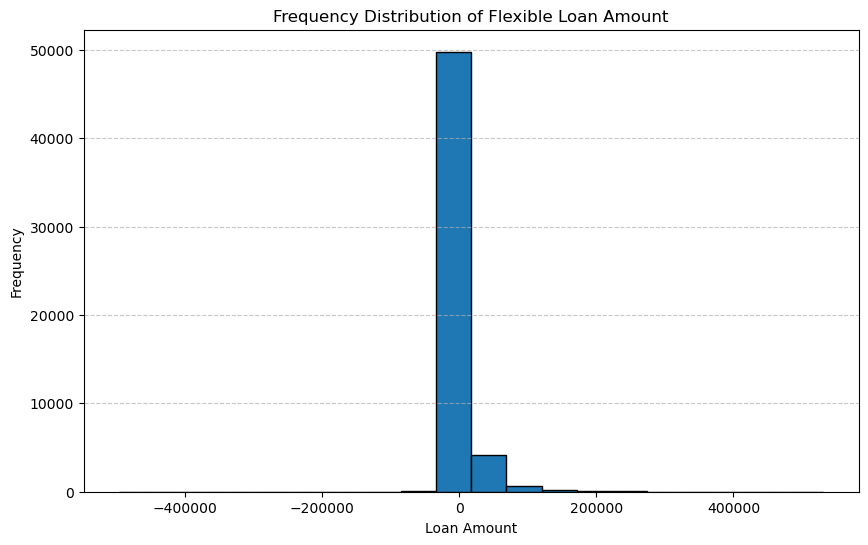

42.73863245547299

In [48]:
# Analyze the FlexibleLoanAmount column
flexible_loan_amount = data['FlexibleLoanAmount']

# Basic statistics for FlexibleLoanAmount
flexible_loan_stats = flexible_loan_amount.describe()

# Frequency distribution for FlexibleLoanAmount
frequency_distribution_flexible_loan = flexible_loan_amount.value_counts(bins=10).reset_index()
frequency_distribution_flexible_loan.columns = ['Loan Amount Range', 'Frequency']

# Plot the frequency distribution
plt.figure(figsize=(10, 6))
plt.hist(flexible_loan_amount.dropna(), bins=20, edgecolor='black')
plt.title('Frequency Distribution of Flexible Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Count the number of missing values in FlexibleLoanAmount
missing_values_count_flexible_loan = flexible_loan_amount.isnull().sum()
missing_percentage_flexible_loan = (missing_values_count_flexible_loan / len(flexible_loan_amount)) * 100
missing_percentage_flexible_loan

In [49]:
# Analyze the `FlexibleLoanAmount` column for zeros and nulls
flexible_loan_analysis = {
    "Zero Values": (data['FlexibleLoanAmount'] == 0).sum(),
    "Null Values": data['FlexibleLoanAmount'].isnull().sum()
}

flexible_loan_analysis


{'Zero Values': 37509, 'Null Values': 41009}

It can be assumed that the missing values are actually zero. It might make sense to explore a relationship between negative values and the credit score, as it is likely that if the mortgage allows withdrawing more money, it is due to a high credit score. Again, this is highly hypothetical, as it could also be because the mortgage carries high interest rates, which is why such a possibility exists.

In [50]:
data['FlexibleLoanAmount'] = data['FlexibleLoanAmount'].fillna(0).apply(lambda x: 0 if x == 0 else 1)
data['FlexibleLoanAmount'] = data['FlexibleLoanAmount'].fillna(0)


category_means = data.groupby('FlexibleLoanAmount')['target'].mean()

category_means

FlexibleLoanAmount
0    0.315214
1    0.116318
Name: target, dtype: float64

In [51]:
# transfor in an Int
data['FlexibleLoanAmount'] = data['FlexibleLoanAmount'].astype(int)

# Verify if there are still null values
null_values_count_flexible_after = data['FlexibleLoanAmount'].isnull().sum()
null_values_count_flexible_after

0

The hypothesis seems correct; non-null values tend to default less frequently.

### 1.1.13. CurrentBalance

This metric can be important both individually on its own and in relation to others.

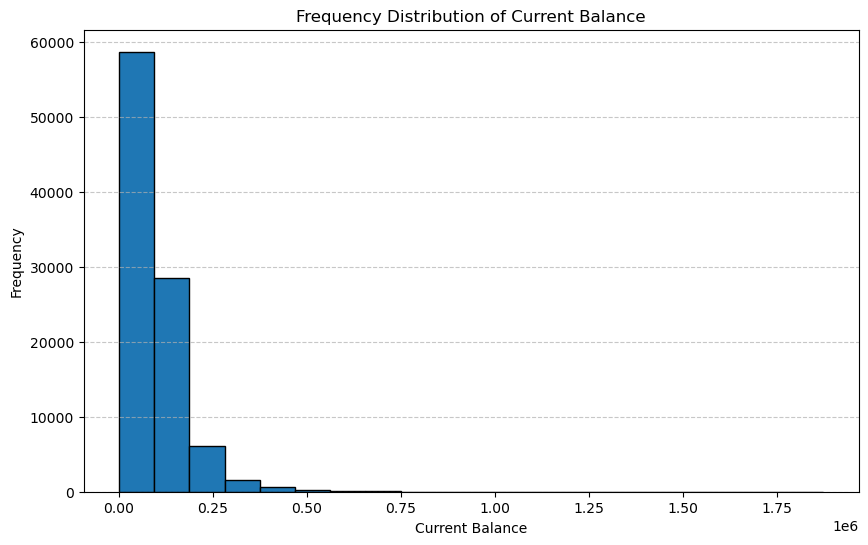

0

In [52]:
# Analyze the CurrentBalance column
current_balance = data['CurrentBalance']

# Basic statistics for CurrentBalance
current_balance_stats = current_balance.describe()

# Frequency distribution for CurrentBalance
frequency_distribution_current_balance = current_balance.value_counts(bins=10).reset_index()
frequency_distribution_current_balance.columns = ['Balance Range', 'Frequency']

# Plot the frequency distribution
plt.figure(figsize=(10, 6))
plt.hist(current_balance.dropna(), bins=20, edgecolor='black')
plt.title('Frequency Distribution of Current Balance')
plt.xlabel('Current Balance')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Count the number of missing values in CurrentBalance
missing_values_count_current_balance = current_balance.isnull().sum()


missing_values_count_current_balance


An ANOVA analysis to check if it is significant. 

In [53]:
balance_target_summary = data.groupby('target')['CurrentBalance'].mean().reset_index()
balance_target_summary.rename(columns={'CurrentBalance': 'Mean_CurrentBalance'}, inplace=True)

# Perform ANOVA to test if the difference in means is statistically significant
from scipy.stats import f_oneway

# Extract CurrentBalance values for each target category
balance_0 = data[data['target'] == 0]['CurrentBalance'].dropna()
balance_1 = data[data['target'] == 1]['CurrentBalance'].dropna()

# Perform ANOVA
anova_stat, anova_p = f_oneway(balance_0, balance_1)

# Prepare results
anova_result = {
    "Mean_CurrentBalance_Target_0": balance_0.mean(),
    "Mean_CurrentBalance_Target_1": balance_1.mean(),
    "ANOVA Statistic": anova_stat,
    "P-Value": anova_p,
    "Is Significant": anova_p < 0.05  # Assuming a significance level of 0.05
}


anova_result

{'Mean_CurrentBalance_Target_0': 89685.62196805204,
 'Mean_CurrentBalance_Target_1': 102614.08809545147,
 'ANOVA Statistic': 523.6059952370413,
 'P-Value': 1.4200440944027613e-115,
 'Is Significant': True}

### 1.1.14. OriginalBalance

This metric can be important both individually on its own and in relation to others.

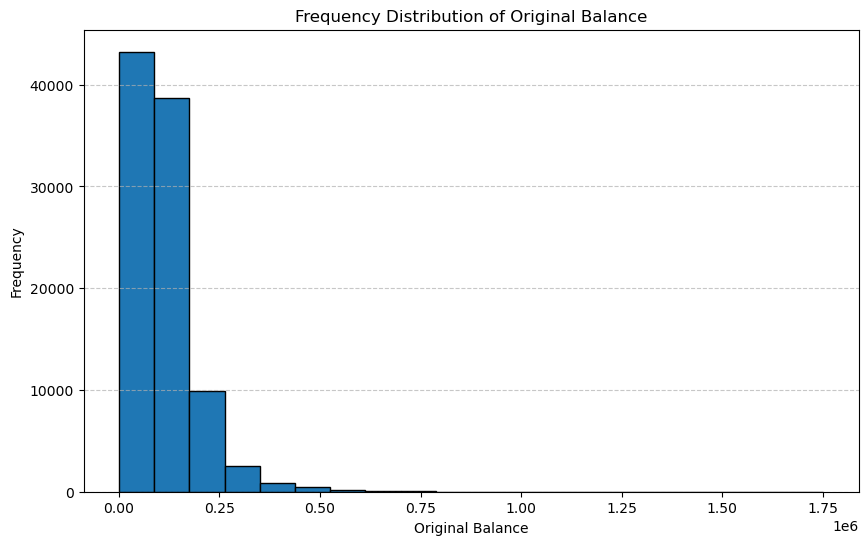

0

In [54]:
# Analyze the OriginalBalance column
original_balance = data['OriginalBalance']

# Basic statistics for OriginalBalance
original_balance_stats = original_balance.describe()

# Frequency distribution for OriginalBalance
frequency_distribution_original_balance = original_balance.value_counts(bins=10).reset_index()
frequency_distribution_original_balance.columns = ['Original Balance Range', 'Frequency']

# Plot the frequency distribution
plt.figure(figsize=(10, 6))
plt.hist(original_balance.dropna(), bins=20, edgecolor='black')
plt.title('Frequency Distribution of Original Balance')
plt.xlabel('Original Balance')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Count the number of missing values in OriginalBalance
missing_values_count_original_balance = original_balance.isnull().sum()


missing_values_count_original_balance


In [55]:

# Calculate the mean of OriginalBalance for each target category
balance_original_summary = data.groupby('target')['OriginalBalance'].mean().reset_index()
balance_original_summary.rename(columns={'OriginalBalance': 'Mean_OriginalBalance'}, inplace=True)

# Perform ANOVA to test if the difference in means is statistically significant
# Extract OriginalBalance values for each target category
original_balance_0 = data[data['target'] == 0]['OriginalBalance'].dropna()
original_balance_1 = data[data['target'] == 1]['OriginalBalance'].dropna()

# Perform ANOVA
anova_original_stat, anova_original_p = f_oneway(original_balance_0, original_balance_1)

# Prepare results
anova_original_result = {
    "Mean_OriginalBalance_Target_0": original_balance_0.mean(),
    "Mean_OriginalBalance_Target_1": original_balance_1.mean(),
    "ANOVA Statistic": anova_original_stat,
    "P-Value": anova_original_p,
    "Is Significant": anova_original_p < 0.05  # Assuming a significance level of 0.05
}



anova_original_result


{'Mean_OriginalBalance_Target_0': 111099.71711225154,
 'Mean_OriginalBalance_Target_1': 112566.54412950929,
 'ANOVA Statistic': 6.492030186616259,
 'P-Value': 0.010837460863969266,
 'Is Significant': True}

### 1.1.15. ForeignNational

In [56]:
# Frequency in percentage for each unique value in 'ForeignNational'
value_percentage_frequency = data['ForeignNational'].value_counts(normalize=True) * 100

value_percentage_frequency


No Data    80.941711
Y          18.432983
N           0.625306
Name: ForeignNational, dtype: float64

In [57]:
# Calculate the mean of target for each ForeignNational category, including "No Data"
foreign_mean_target_with_nodata = data.groupby('ForeignNational')['target'].mean().reset_index()
foreign_mean_target_with_nodata.rename(columns={'target': 'Mean_Target'}, inplace=True)
foreign_mean_target_with_nodata


,ForeignNational,Mean_Target
0,N,0.206667
1,No Data,0.286483
2,Y,0.248996


There are likely significant differences between National and Foreign; however, with 80% of the data missing, drawing conclusions is premature. Therefore, this column will be deleted.

In [58]:
data.drop(columns=['ForeignNational'], inplace=True)

### 1.1.16. GeographicRegionList

In [59]:
# Basic statistics of 'GeographicRegionList'
geographic_region_stats = data['GeographicRegionList'].describe()

# Frequency in percentage for each unique value in 'GeographicRegionList'
geographic_region_percentage_frequency = data['GeographicRegionList'].value_counts(normalize=True) * 100

geographic_region_stats, geographic_region_percentage_frequency

(count     95953
 unique      134
 top       UKZZZ
 freq      51229
 Name: GeographicRegionList, dtype: object,
 UKZZZ    53.389680
 UKJ11     1.855075
 UKD11     1.321480
 UKI11     1.288131
 UKI21     1.089075
            ...    
 UKL12     0.051067
 UKM61     0.046898
 UKM64     0.015633
 UKM66     0.012506
 UKM65     0.004169
 Name: GeographicRegionList, Length: 134, dtype: float64)

In [60]:
# Create a new column for GeographicRegionList with two categories: UKZZZ and Other
data['GeographicRegionList_Categorized'] = data['GeographicRegionList'].apply(
    lambda x: 'UKZZZ' if x == 'UKZZZ' else 'Other'
)

# Prepare a contingency table for the new column and target
contingency_table_geo = pd.crosstab(data['GeographicRegionList_Categorized'], data['target'])

# Perform the Chi-Square test
chi2_geo, p_geo, dof_geo, expected_geo = chi2_contingency(contingency_table_geo)

# Prepare results
geo_result = {
    "Chi2 Statistic": chi2_geo,
    "P-Value": p_geo,
    "Degrees of Freedom": dof_geo,
    "Is Significant": p_geo < 0.05  # Assuming a significance level of 0.05
}

geo_result


{'Chi2 Statistic': 143.33446708715633,
 'P-Value': 4.967088047454273e-33,
 'Degrees of Freedom': 1,
 'Is Significant': True}

In [61]:
data = data.drop('GeographicRegionList', axis = 1)

### 1.1.17. LoanAge

In [62]:
data['PoolCutoffDate'] = pd.to_datetime(data['PoolCutoffDate'], errors='coerce', format='%m/%d/%Y')
data['LoanOriginationDate'] = pd.to_datetime(data['LoanOriginationDate'], errors='coerce', format='%m/%d/%Y')

# Calculate the loan age based on the difference in months between the two dates
data['CalculatedLoanAge'] = (data['PoolCutoffDate'] - data['LoanOriginationDate']).dt.days // 30

# Compute the absolute difference between the provided and calculated LoanAge
data['AbsoluteLoanAgeDifference'] = (data['LoanAge'] - data['CalculatedLoanAge']).abs()

# Analyze the absolute differences
absolute_difference_stats = data['AbsoluteLoanAgeDifference'].describe()
difference_greater_than_six = (data['AbsoluteLoanAgeDifference'] > 6).sum()

# Output results
print("Statistical Analysis of Absolute Differences:")
print(absolute_difference_stats)
print(f"\nNumber of cases with an absolute difference greater than 6 months: {difference_greater_than_six}")


Statistical Analysis of Absolute Differences:
count    95953.000000
mean         2.354121
std          7.616726
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max        598.000000
Name: AbsoluteLoanAgeDifference, dtype: float64

Number of cases with an absolute difference greater than 6 months: 1545


In [63]:
data = data.drop('CalculatedLoanAge', axis=1)
data = data.drop('AbsoluteLoanAgeDifference', axis=1)


For all values in *LoanAge*, there is a discrepancy between the expected dates and *LoanAge*. One possibility would be to delete entries with discrepancies, as the presence of an error might indicate other errors. However, they will be left as they are. Further investigation into the origin of these discrepancies is left for future work.

### 1.1.18. Purpose

In [64]:
analysis = data[['Purpose', 'target']].copy()

# Convert 'target' to numeric if not already
analysis['target'] = pd.to_numeric(analysis['target'], errors='coerce')

# Group by 'Purpose', calculate frequency and mean (probability of target = 1)
summary_table = (
    analysis.groupby('Purpose')
    .agg(frequency=('Purpose', 'size'), target_probability=('target', 'mean'))
    .reset_index()
)

# Sort by frequency in descending order
summary_table = summary_table.sort_values(by='frequency', ascending=False)
summary_table


,Purpose,frequency,target_probability
6,PURCHASE,54654,0.275149
7,REMORTGAGE,30954,0.251502
1,DEBT CONSOLIDATION,3207,0.418148
8,REMORTGAGE EQUITY RELEASE,1994,0.379639
10,RENOVATION,1322,0.267776
2,EQUITY RELEASE,1244,0.431672
11,RIGHT TO BUY,962,0.494802
3,INVESTMENT,706,0.262040
4,NO DATA,545,0.344954
5,OTHER,294,0.363946


To prioritize the robustness of the model, the categories NO DATA, OTHER, REMORTGAGE NEW TERMS, and CONSTRUCTION will be grouped under OTHER.

In [65]:
replacement_values = ['NO DATA', 'OTHER', 'REMORTGAGE NEW TERMS', 'CONSTRUCTION']
data['Purpose'] = data['Purpose'].replace(replacement_values, 'OTHER')

# Recalculate the summary table with the updated 'Purpose' values
analysis = data[['Purpose', 'target']].copy()
analysis['target'] = pd.to_numeric(analysis['target'], errors='coerce')

summary_table_updated = (
    analysis.groupby('Purpose')
    .agg(frequency=('Purpose', 'size'), target_probability=('target', 'mean'))
    .reset_index()
    .sort_values(by='frequency', ascending=False)
)
summary_table_updated

,Purpose,frequency,target_probability
4,PURCHASE,54654,0.275149
5,REMORTGAGE,30954,0.251502
0,DEBT CONSOLIDATION,3207,0.418148
6,REMORTGAGE EQUITY RELEASE,1994,0.379639
7,RENOVATION,1322,0.267776
1,EQUITY RELEASE,1244,0.431672
8,RIGHT TO BUY,962,0.494802
3,OTHER,910,0.335165
2,INVESTMENT,706,0.262040


### 1.1.19. CLTV

CLTV is a very important ratio; it seems intuitive that the higher the debt value compared to the house value, the greater the likelihood of default.

In [66]:
# Statistical analysis of the 'CLTV' column
cltv_stats = data['CLTV'].describe()

# Count of missing or null values in the 'CLTV' column
cltv_missing = data['CLTV'].isnull().sum()

cltv_stats, cltv_missing


(count    9.592400e+04
 mean     1.698662e+02
 std      1.808342e+04
 min      7.853181e-02
 25%      2.423791e+01
 50%      4.812928e+01
 75%      7.052096e+01
 max      4.130223e+06
 Name: CLTV, dtype: float64,
 29)

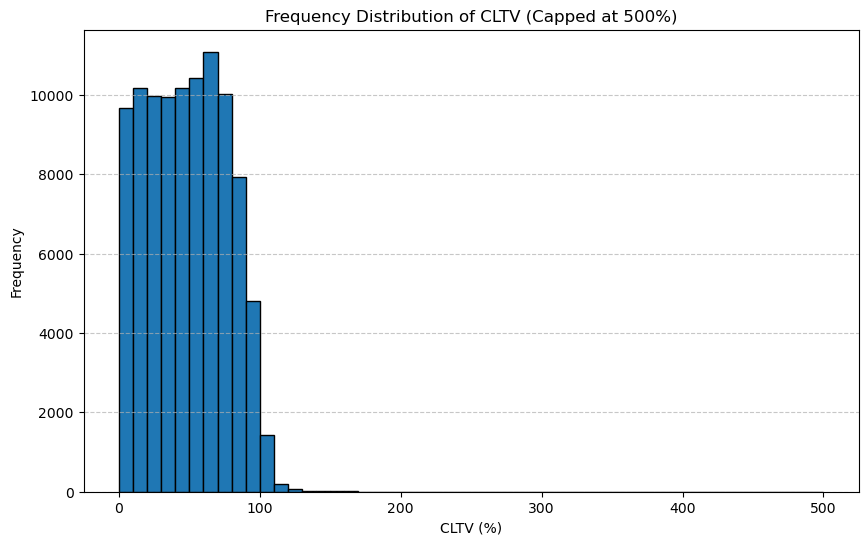

In [67]:
# Plotting the histogram of CLTV, excluding null values
plt.figure(figsize=(10, 6))
data['CLTV'].dropna().plot(kind='hist', bins=50, range=(0, 500), edgecolor='black')  # Restricting range to focus on most data points
plt.title('Frequency Distribution of CLTV (Capped at 500%)')
plt.xlabel('CLTV (%)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [68]:
# Count the number of cases where CLTV is greater than 500%
cltv_greater_than_500 = (data['CLTV'] > 500).sum()

cltv_greater_than_500


5

In [69]:
# Remove rows where CLTV is greater than 500%
data = data[data['CLTV'] <= 500]

Since there are very few values, they are likely registration errors and will therefore be deleted. A more in-depth study could be conducted, but it is beyond the scope of this project.

### 1.1.20. TotalIncome

TotalIncome is another important variable that can provide significant information both individually and as part of a ratio.

In [70]:
# Perform an exhaustive statistical analysis of the TotalIncome variable
total_income_stats = data['TotalIncome'].describe()

# Additional metrics for detailed analysis
variance = data['TotalIncome'].var()
skewness = data['TotalIncome'].skew()
kurtosis = data['TotalIncome'].kurt()

# Consolidate all statistics
analysis = {
    "Count": total_income_stats["count"],
    "Mean": total_income_stats["mean"],
    "Std Dev": total_income_stats["std"],
    "Min": total_income_stats["min"],
    "25%": total_income_stats["25%"],
    "Median (50%)": total_income_stats["50%"],
    "75%": total_income_stats["75%"],
    "Max": total_income_stats["max"],
    "Variance": variance,
    "Skewness": skewness,
    "Kurtosis": kurtosis,
}

analysis


{'Count': 95919.0,
 'Mean': 41705.02540977283,
 'Std Dev': 45683.7914429812,
 'Min': 0.0,
 '25%': 23500.0,
 'Median (50%)': 34600.0,
 '75%': 50000.0,
 'Max': 5131000.0,
 'Variance': 2087008800.6058025,
 'Skewness': 35.87926038964395,
 'Kurtosis': 3084.9966075821585}

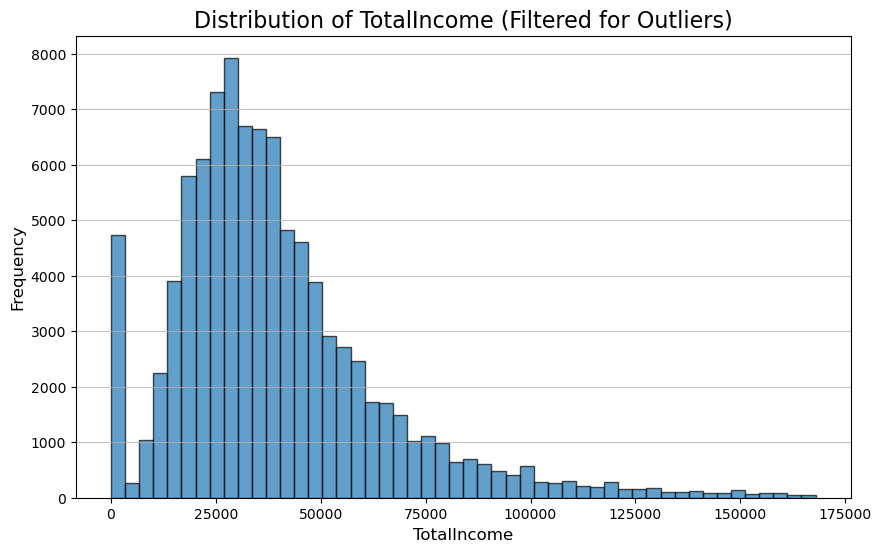

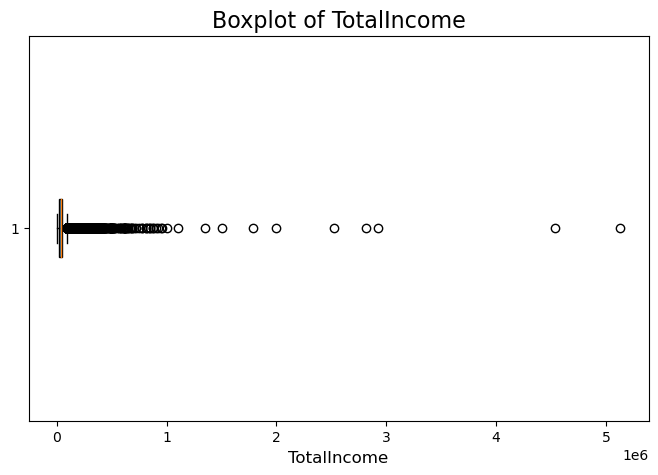

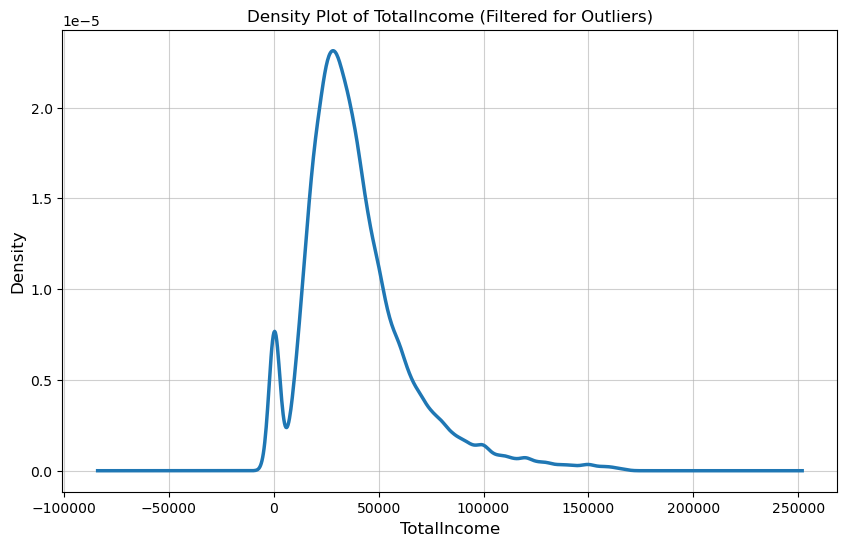

In [71]:
# Filter data to exclude outliers for better visualization
filtered_data = data['TotalIncome'][data['TotalIncome'] < data['TotalIncome'].quantile(0.99)]

# Histogram of TotalIncome distribution (with outlier filtering for readability)
plt.figure(figsize=(10, 6))
plt.hist(filtered_data, bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of TotalIncome (Filtered for Outliers)', fontsize=16)
plt.xlabel('TotalIncome', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

# Boxplot to highlight outliers
plt.figure(figsize=(8, 5))
plt.boxplot(data['TotalIncome'], vert=False, patch_artist=True, showfliers=True)
plt.title('Boxplot of TotalIncome', fontsize=16)
plt.xlabel('TotalIncome', fontsize=12)
plt.show()

# Density plot
plt.figure(figsize=(10, 6))
filtered_data.plot(kind='kde', title='Density Plot of TotalIncome (Filtered for Outliers)', linewidth=2.5)
plt.xlabel('TotalIncome', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(alpha=0.6)
plt.show()


Those zeros in TotalIncome seem to be data artifacts. To verify this, we will check their BorrowerEmployed category. If they are employed or we can confirm that they have an income, we can conclude that their TotalIncome is not zero but rather higher.

In [72]:
employment_categories_total_income_zero = data[data['TotalIncome'] == 0]['BorrowersEmploymentStatus'].value_counts()

employment_categories_total_income_zero

NO DATA          1854
EMPLOYED          756
SELF EMPLOYED     284
OTHER             111
Name: BorrowersEmploymentStatus, dtype: int64

In [73]:
# Replace 0 values in 'TotalIncome' column using a different method to avoid recursion issues
data.loc[data['TotalIncome'] == 0, 'TotalIncome'] = pd.NA

# Verify the changes
null_count_final = data['TotalIncome'].isna().sum()
null_count_final

3005

## 1.2 Handling of missing values

### 1.2.1 CLTV, CurrentValuationAmount, Current Valance

The values ​​do not match, but according to the description they should be the same, so the formula indicated in the description will be used as a proxy.

In [74]:
# Ensure the relevant columns are numeric
data['CurrentBalance'] = pd.to_numeric(data['CurrentBalance'], errors='coerce')
data['CLTV'] = pd.to_numeric(data['CLTV'], errors='coerce')
data['CurrentValuationAmount'] = pd.to_numeric(data['OriginalBalance'], errors='coerce')

# Fill missing CLTV with CurrentBalance / CurrentValuationAmount
data['CLTV'] = data['CLTV'].fillna(data['CurrentBalance'] / data['CurrentValuationAmount'])

# Fill missing CurrentBalance with CLTV * CurrentValuationAmount
data['CurrentBalance'] = data['CurrentBalance'].fillna(data['CLTV'] * data['CurrentValuationAmount'])

# Fill missing CurrentValuationAmount with CurrentBalance / CLTV
data['CurrentValuationAmount'] = data['CurrentValuationAmount'].fillna(data['CurrentBalance'] / data['CLTV'])

### 1.2.2. BorrowerYearOfBirth & BorrowerCreditQuality

Probably one of the most important variables for predicting a default. The relationship between frequency, interest rates, credit score categories and credit score is recalled.

In [75]:
# Recalculate frequency
frequency = data['BorrowerCreditQuality'].value_counts()

# Recalculate the relationship for target values
relationship = data.groupby('BorrowerCreditQuality')['target'].value_counts(normalize=True).unstack()
relationship_percentage = relationship.fillna(0) * 100  # Convert to percentages

# Add the frequency column
relationship_percentage['Frequency'] = frequency

# Calculate the mean BureauScoreValue
bureau_score_mean = data.groupby('BorrowerCreditQuality')['BureauScoreValue'].mean()
relationship_percentage['Mean BureauScoreValue'] = bureau_score_mean

# Calculate the mean CurrentInterestRate and CurrentInterestRateMargin
current_interest_rate_mean = data.groupby('BorrowerCreditQuality')['CurrentInterestRate'].mean()
current_interest_rate_margin_mean = data.groupby('BorrowerCreditQuality')['CurrentInterestRateMargin'].mean()
relationship_percentage['Mean CurrentInterestRate'] = current_interest_rate_mean
relationship_percentage['Mean CurrentInterestRateMargin'] = current_interest_rate_margin_mean

# Sort by frequency
relationship_percentage_sorted = relationship_percentage.sort_values(by='Frequency', ascending=False)
relationship_percentage_sorted

target,0,1,Frequency,Mean BureauScoreValue,Mean CurrentInterestRate,Mean CurrentInterestRateMargin
BorrowerCreditQuality,,,,,,
No Data,65.145505,34.854495,46390,590.890644,3.839131,2.986254
PRIME,82.424349,17.575651,39788,979.497422,2.728705,0.976725
PASS TYPE A,69.930814,30.069186,3758,NaN,3.659143,0.947560
PASS TYPE B,63.250672,36.749328,3347,NaN,3.691772,0.703397
PASS TYPE C,52.302763,47.697237,2497,NaN,3.759772,0.721538
Vida 1,78.947368,21.052632,57,NaN,3.906667,3.825088
Acquired,54.166667,45.833333,48,NaN,3.318946,2.511862
Vida 2,61.538462,38.461538,13,NaN,4.390000,4.390000
Vida 3,75.000000,25.000000,8,NaN,4.633750,4.633750


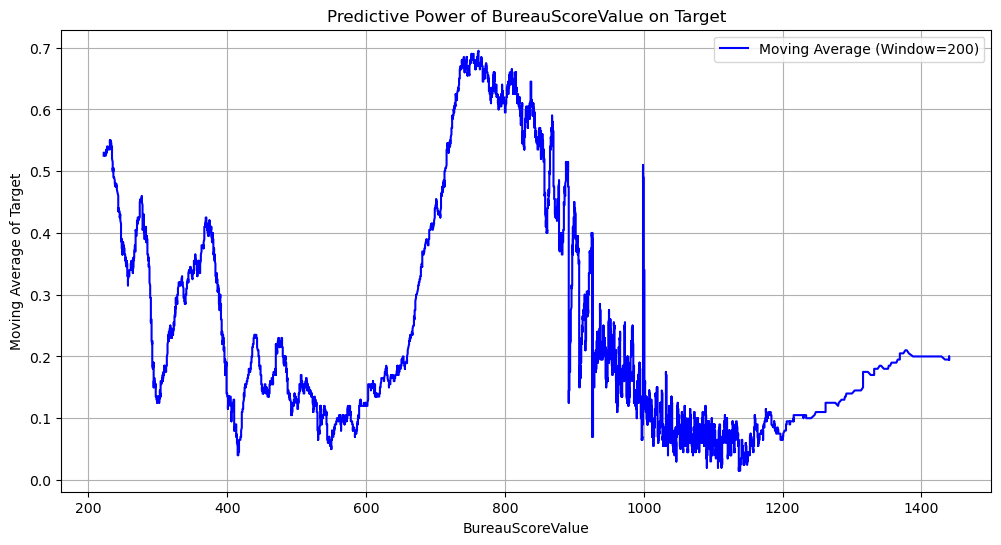

In [76]:
# Create a temporary copy of the dataset for analysis
temp_data = data.copy()

# Convert columns to numeric without modifying the original dataset
temp_data['BureauScoreValue'] = pd.to_numeric(temp_data['BureauScoreValue'], errors='coerce')
temp_data['target'] = pd.to_numeric(temp_data['target'], errors='coerce')

# Sort and filter the data
temp_data = temp_data.sort_values(by='BureauScoreValue').dropna(subset=['BureauScoreValue', 'target'])

# Calculate the rolling mean of the target variable with a window of 200
rolling_mean = temp_data['target'].rolling(window=200).mean()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(temp_data['BureauScoreValue'], rolling_mean, label='Moving Average (Window=200)', color='blue')
plt.title('Predictive Power of BureauScoreValue on Target')
plt.xlabel('BureauScoreValue')
plt.ylabel('Moving Average of Target')
plt.grid(True)
plt.legend()
plt.show()

Based on the reasoning outlined in 1.1.6 Borrower Credit Quality, it is reasonable to assume that the investable categories (PRIME, PASS TYPE A, PASS TYPE B, PASS TYPE C) are located in the range from 800 to 1200, with "Acquired" likely around 780, and the remaining categories positioned to the left.

The project could be further refined, but due to scope limitations, it will be addressed using the following heuristic. To replace the missing "BureauScoreValue" values in the dataset, the target percentage of those four categories is used to extract the BureauScoreValue, resulting in: Acquired 780, PASS TYPE C 830, PASS TYPE B 860, PASS TYPE A 880, PRIME 980.

In [77]:
credit_quality_to_score = {
    'Acquired': 780,
    'PASS TYPE C': 830,
    'PASS TYPE B': 860,
    'PASS TYPE A': 880,
    'PRIME': 980
}

# Replace missing BureauScoreValue based on BorrowerCreditQuality
data['BureauScoreValue'] = data.apply(
    lambda row: credit_quality_to_score[row['BorrowerCreditQuality']]
    if pd.isna(row['BureauScoreValue']) and row['BorrowerCreditQuality'] in credit_quality_to_score
    else row['BureauScoreValue'],
    axis=1
)

The remaining categories are merged due to the small amount of data, which implies a loss of information but reflects similar characteristics.

In [78]:
# Define the categories to group and assign a BureauScoreValue of 400
categories_to_update = ['Vida 1', 'Vida 2', 'Vida 3', 'Vida 4', 'Vida 5', 'Near Prime']

# Update BureauScoreValue to 400 for the specified categories with missing values
data['BureauScoreValue'] = data.apply(
    lambda row: 400 if pd.isna(row['BureauScoreValue']) and row['BorrowerCreditQuality'] in categories_to_update
    else row['BureauScoreValue'],
    axis=1
)

data['BorrowerCreditQuality'] = data['BorrowerCreditQuality'].replace(
    categories_to_update, 'distress'
)

The "No Data" entries in BureauScoreValue could potentially be categorized using the previous reasoning, but due to the project's scope, a unique category will be created for them when generating the dummy variables.

In [79]:
# Recalculate frequency
frequency = data['BorrowerCreditQuality'].value_counts()

# Recalculate the relationship for target values
relationship = data.groupby('BorrowerCreditQuality')['target'].value_counts(normalize=True).unstack()
relationship_percentage = relationship.fillna(0) * 100  # Convert to percentages

# Add the frequency column
relationship_percentage['Frequency'] = frequency

# Calculate the mean BureauScoreValue
bureau_score_mean = data.groupby('BorrowerCreditQuality')['BureauScoreValue'].mean()
relationship_percentage['Mean BureauScoreValue'] = bureau_score_mean

# Calculate the mean CurrentInterestRate and CurrentInterestRateMargin
current_interest_rate_mean = data.groupby('BorrowerCreditQuality')['CurrentInterestRate'].mean()
current_interest_rate_margin_mean = data.groupby('BorrowerCreditQuality')['CurrentInterestRateMargin'].mean()
relationship_percentage['Mean CurrentInterestRate'] = current_interest_rate_mean
relationship_percentage['Mean CurrentInterestRateMargin'] = current_interest_rate_margin_mean

# Sort by frequency
relationship_percentage_sorted = relationship_percentage.sort_values(by='Frequency', ascending=False)
relationship_percentage_sorted

target,0,1,Frequency,Mean BureauScoreValue,Mean CurrentInterestRate,Mean CurrentInterestRateMargin
BorrowerCreditQuality,,,,,,
No Data,65.145505,34.854495,46390,590.890644,3.839131,2.986254
PRIME,82.424349,17.575651,39788,979.567059,2.728705,0.976725
PASS TYPE A,69.930814,30.069186,3758,880.000000,3.659143,0.947560
PASS TYPE B,63.250672,36.749328,3347,860.000000,3.691772,0.703397
PASS TYPE C,52.302763,47.697237,2497,830.000000,3.759772,0.721538
distress,70.329670,29.670330,91,386.725275,4.449396,4.203098
Acquired,54.166667,45.833333,48,780.000000,3.318946,2.511862


### 1.2.3. BorrowersEmploymentStatus 

BorrowersEmploymentStatus has a category that dominates the others, it is assumed that the missing variables have been deleted randomly, so the most frequent variable is chosen as the predictor.

In [80]:
# Replace "NO DATA" in the BorrowersEmploymentStatus column with the most frequent category
most_frequent_category = data['BorrowersEmploymentStatus'].mode()[0]
data['BorrowersEmploymentStatus'] = data['BorrowersEmploymentStatus'].replace("NO DATA", most_frequent_category)

# Verify the changes
updated_data_preview = data['BorrowersEmploymentStatus'].value_counts()
updated_data_preview


EMPLOYED         80725
SELF EMPLOYED    11286
OTHER             3908
Name: BorrowersEmploymentStatus, dtype: int64

### 1.2.4  Dummies

Categorical variables are transformed into dummies.

In [81]:
data = pd.get_dummies(data, columns=['ID_Prefix'], prefix='Prefix', drop_first=True)

data = pd.get_dummies(data, columns=['BorrowersEmploymentStatus'], prefix='Prefix', drop_first=True)

data = pd.get_dummies(data, columns=['Purpose'], prefix='Purpose', drop_first=True )

data = pd.get_dummies(data, columns=['GeographicRegionList_Categorized'], drop_first=True)

data = pd.get_dummies(data, columns=['FirstTimeBuyer'], drop_first=True)

data = pd.get_dummies(data, columns=['BorrowerCreditQuality'], drop_first=True)

columns_to_remove = ['ID_Prefix', 'BorrowersEmploymentStatus', 'Purpose', 
                     'GeographicRegionList_Categorized', 'FirstTimeBuyer', 'PoolCutoffDate','LoanOriginationDate', 'DateOfLoanMaturity' ]

data.drop(columns=columns_to_remove, inplace=True, errors='ignore')

In [83]:
# Show columns with the number of null values
nulos_por_columna = data.isnull().sum()

# Filter and display only columns with null values
columnas_con_nulos = nulos_por_columna[nulos_por_columna > 0]
print(columnas_con_nulos)


BureauScoreValue        42856
TotalIncome              3005
AgeAtLoanOrigination    40784
dtype: int64


### 1.2.5. TotalIncome & AgeLoanOrigination

In [84]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


# Back up the target variable to re-add it later
target_column = 'target'
target_backup = data[target_column].copy()

# Function to fill missing values using Random Forest
def fill_missing_rf(df, target_column, predictors):
    # Separate rows with and without missing values
    df_missing = df[df[target_column].isnull()]
    df_not_missing = df[~df[target_column].isnull()]

    # If no missing values, return original dataframe
    if df_missing.empty:
        return df

    # Define predictors and target
    X = df_not_missing[predictors]
    y = df_not_missing[target_column]

    # Train/test split to prevent overfitting during model training
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Random Forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Predict missing values
    X_missing = df_missing[predictors]
    predicted_values = rf.predict(X_missing)

    # Fill in missing values in the original dataframe
    df.loc[df[target_column].isnull(), target_column] = predicted_values

    return df

# Identify predictors for the imputations
columns_to_exclude = ['TotalIncome', 'AgeAtLoanOrigination', 'BureauScoreValue', 'target']  # Exclude target and missing columns
predictors = [col for col in data.columns if col not in columns_to_exclude]


# Fill missing values for TotalIncome
data = fill_missing_rf(data, 'TotalIncome', predictors)

# Recalculate predictors after updating TotalIncome
columns_to_exclude = ['AgeAtLoanOrigination', 'BureauScoreValue', 'target']  # Exclude updated columns and target
predictors = [col for col in data.columns if col not in columns_to_exclude]

# Fill missing values for AgeLoanOrigination
data = fill_missing_rf(data, 'AgeAtLoanOrigination', predictors)

# Recalculate predictors after updating AgeLoanOrigination
columns_to_exclude = ['BureauScoreValue', 'target']  # Exclude updated columns and target
predictors = [col for col in data.columns if col not in columns_to_exclude]

# Fill missing values for BureauScoreValue
data = fill_missing_rf(data, 'BureauScoreValue', predictors)

# Re-add the target variable to the dataset
data[target_column] = target_backup

# Save the cleaned dataset
data.to_csv('completed_data.csv', index=False)

print("Missing values filled, target re-added, and saved to 'completed_data.csv'.")




Missing values filled, target re-added, and saved to 'cleaned_data_with_target.csv'.
